In [1]:
import pandas as pd

import numpy as np

import itertools

from datetime import datetime

import time

import pytz
import sys
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score

import seaborn as sns

import MetaTrader5 as mt5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping

# LOAD DATA

In [2]:
sSymbol = "NAT.GAS"
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2021, 11, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2021, 11, 20, tzinfo=gc_o_TIME_ZONE)

In [3]:
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())
    sys.exit()

aSymbolInfo = mt5.symbol_info(sSymbol)
if not aSymbolInfo:
    print("symbol_info() failed, error code =", mt5.last_error())
    sys.exit()

dfOhlc = mt5.copy_rates_range(
    sSymbol,
    mt5.TIMEFRAME_M1,
    gc_dt_FROM, 
    gc_dt_TO,
)

if len(dfOhlc) == 0:
    print("copy_rates_range() failed, error code =", mt5.last_error())
    sys.exit()

mt5.shutdown()

dfOhlc = pd.DataFrame(dfOhlc)

dfOhlc['timestamp'] = pd.to_datetime(dfOhlc['time'], unit= "s")
dfOhlc.set_index('timestamp', inplace=True)

In [4]:
dfOhlc["weekday"] = dfOhlc.index.weekday
dfOhlc["hour"] = dfOhlc.index.hour
dfOhlc["minute"] = dfOhlc.index.minute

In [5]:
dfOhlc.drop(["time"], axis = 1 , inplace = True)

# DESCRIBE DATA

In [6]:
dfOhlc

,open,high,low,close,tick_volume,spread,real_volume,weekday,hour,minute
timestamp,,,,,,,,,,
2021-11-01 00:00:00,5.341,5.366,5.335,5.338,160,4,1597000,0,0,0
2021-11-01 00:01:00,5.340,5.342,5.330,5.332,55,4,550000,0,0,1
2021-11-01 00:02:00,5.332,5.345,5.332,5.342,42,10,420000,0,0,2
2021-11-01 00:03:00,5.343,5.346,5.334,5.334,27,10,267000,0,0,3
2021-11-01 00:04:00,5.333,5.333,5.324,5.328,14,10,137000,0,0,4
...,...,...,...,...,...,...,...,...,...,...
2021-11-19 23:55:00,5.132,5.134,5.131,5.134,6,10,60000,4,23,55
2021-11-19 23:56:00,5.136,5.136,5.135,5.135,4,10,40000,4,23,56
2021-11-19 23:57:00,5.137,5.137,5.133,5.133,7,10,70000,4,23,57


# PREPROCESSING

In [7]:
sModelName = os.path.join(sSymbol , "__deep learning model__")

## Split Data

In [8]:
fTrainingRatio = 0.6
fValidationRatio = 0.2
fTestRatio = 0.2

ixTrain, ixTest = train_test_split(
    dfOhlc.index,
    test_size=1-fTrainingRatio,
    shuffle=False)

ixValidation, ixTest= train_test_split(
    ixTest,
    test_size=fTestRatio/(fTestRatio + fValidationRatio),
    shuffle=False)

## Scale Data

In [40]:
dfScaledOhlc = pd.DataFrame(index = dfOhlc.index, columns  = dfOhlc.columns)


for sColumn in dfOhlc.columns:
    oScaler = StandardScaler()
    
    dfTrain = pd.DataFrame(dfOhlc.loc[ixTrain, sColumn])
    dfValidation = pd.DataFrame(dfOhlc.loc[ixValidation, sColumn])
    dfTest = pd.DataFrame(dfOhlc.loc[ixTest, sColumn])
    
    oScaler.fit(dfTrain)
    
    dfScaledOhlc.loc[ixTrain, sColumn] = np.reshape(oScaler.transform(dfTrain), (-1))
    dfScaledOhlc.loc[ixValidation, sColumn] = np.reshape(oScaler.transform(dfValidation), (-1))
    dfScaledOhlc.loc[ixTest, sColumn] = np.reshape(oScaler.transform(dfTest), (-1))

    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))

## Feature Engineering

In [41]:
aInputFeatures = ['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume','weekday', 'hour', 'minute']
iBackwardTimeWindow = 60
iNrInputFeatures = len(aInputFeatures)
aBackwardTimeSteps = range(-iBackwardTimeWindow, 0)

tplInputColumns = list(itertools.product(aBackwardTimeSteps, aInputFeatures))
miInputColums = pd.MultiIndex.from_tuples(tplInputColumns, names= ["time_step", "feature"])

dfInput = pd.DataFrame( columns = miInputColums)

for i in aBackwardTimeSteps:
    for sInputFeature in aInputFeatures:
        dfInput.loc[:, (i, sInputFeature)] = dfScaledOhlc[sInputFeature].shift(-i)

In [42]:
aOutputFeatures = ['close']
iForwardTimeWindow  =  60
iNrOutputFeatures = len(aOutputFeatures)
aForwardTimeSteps = range(0, iForwardTimeWindow)

tplOutputColumns = list(itertools.product(aForwardTimeSteps, aOutputFeatures))
ixOutputColums = pd.MultiIndex.from_tuples(tplOutputColumns, names= ["time_step", "feature"])

dfOutput = pd.DataFrame(columns = ixOutputColums)

for i in aForwardTimeSteps:
    for sOutputFeature in aOutputFeatures:
        dfOutput.loc[:, (i, sOutputFeature)] = dfScaledOhlc[sOutputFeature].shift(-i)

In [43]:
dfMerged = dfInput.join(dfOutput, how= "inner")
dfMerged.dropna(inplace=True)
dfInput = dfMerged[dfInput.columns]
dfOutput = dfMerged[dfOutput.columns]
ixTrain = ixTrain.join(dfMerged.index, how = "inner")
ixValidation = ixValidation.join(dfMerged.index, how = "inner")
ixTest = ixTest.join(dfMerged.index, how = "inner")

In [44]:
dfInputTrain = dfInput.loc[ixTrain]
aInputTrain = np.reshape(dfInputTrain.values, (dfInputTrain.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputValidation = dfInput.loc[ixValidation]
aInputValidation = np.reshape(dfInputValidation.values, (dfInputValidation.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfInputTest = dfInput.loc[ixTest]
aInputTest = np.reshape(dfInputTest.values, (dfInputTest.shape[0], iBackwardTimeWindow, iNrInputFeatures))

dfOutputTrain = dfOutput.loc[ixTrain]
aOutputTrain = np.reshape(dfOutputTrain.values, (dfOutputTrain.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputValidation = dfOutput.loc[ixValidation]
aOutputValidation = np.reshape(dfOutputValidation.values, (dfOutputValidation.shape[0], iForwardTimeWindow, iNrOutputFeatures))

dfOutputTest = dfOutput.loc[ixTest]
aOutputTest = np.reshape(dfOutputTest.values, (dfOutputTest.shape[0], iForwardTimeWindow, iNrOutputFeatures))

In [45]:
aInputTrain = np.asarray(aInputTrain, np.float32)
aInputValidation = np.asarray(aInputValidation, np.float32)
aInputTest = np.asarray(aInputTest, np.float32)
aOutputTrain = np.asarray(aOutputTrain, np.float32)
aOutputValidation = np.asarray(aOutputValidation, np.float32)
aOutputTest = np.asarray(aOutputTest, np.float32)

## Train

### Set Hyperparameters

In [46]:
iBatchSize = 128
iEpochSize = 10000

oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)

oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 20, 
    restore_best_weights = True)

### Build Model

In [47]:
aInputs = keras.Input(
    shape=(iBackwardTimeWindow, iNrInputFeatures), 
    name="aInputs")

aW1 = LSTM(32, return_sequences = False)(aInputs)
aW2 = Dense(iForwardTimeWindow * iNrOutputFeatures, 
                          kernel_initializer=tf.initializers.zeros(), 
                          name = "aOutputs")(aW1)
aOutputs = Reshape([iForwardTimeWindow, iNrOutputFeatures])(aW2)

oPredictiveModel = keras.Model(
    inputs=aInputs, 
    outputs=aOutputs
)

### Compile Model

In [48]:
oFnLoss =  tf.keras.losses.MeanSquaredError()
oPredictiveModel.compile(optimizer=oOptimizer,
                         loss = oFnLoss
                        )

### Fit Model

In [49]:
oPredictiveModel.fit(
    aInputTrain, 
    aOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (aInputValidation, aOutputValidation),
    validation_batch_size= iBatchSize,
    callbacks=[oEarlyStop]
)

Epoch 1/10000
92/92 [==============================] - 8s 22ms/step - loss: 1.0027 - val_loss: 1.6585
Epoch 2/10000
92/92 [==============================] - 1s 10ms/step - loss: 0.9945 - val_loss: 1.6454
Epoch 3/10000
92/92 [==============================] - 1s 10ms/step - loss: 0.9848 - val_loss: 1.6297
Epoch 4/10000
92/92 [==============================] - 1s 10ms/step - loss: 0.9732 - val_loss: 1.6113
Epoch 5/10000
92/92 [==============================] - 1s 10ms/step - loss: 0.9595 - val_loss: 1.5901
Epoch 6/10000
92/92 [==============================] - 1s 10ms/step - loss: 0.9438 - val_loss: 1.5656
Epoch 7/10000
92/92 [==============================] - 1s 10ms/step - loss: 0.9260 - val_loss: 1.5381
Epoch 8/10000
92/92 [==============================] - 1s 10ms/step - loss: 0.9061 - val_loss: 1.5077
Epoch 9/10000
92/92 [==============================] - 1s 9ms/step - loss: 0.8843 - val_loss: 1.4743
Epoch 10/10000
92/92 [==============================] - 1s 8ms/step - loss: 0.8608 

92/92 [==============================] - 1s 11ms/step - loss: 0.0479 - val_loss: 0.1187
Epoch 81/10000
92/92 [==============================] - 1s 11ms/step - loss: 0.0463 - val_loss: 0.1135
Epoch 82/10000
92/92 [==============================] - 1s 13ms/step - loss: 0.0449 - val_loss: 0.1086
Epoch 83/10000
92/92 [==============================] - 1s 13ms/step - loss: 0.0435 - val_loss: 0.1035
Epoch 84/10000
92/92 [==============================] - 1s 12ms/step - loss: 0.0422 - val_loss: 0.0986
Epoch 85/10000
92/92 [==============================] - 1s 13ms/step - loss: 0.0409 - val_loss: 0.0938
Epoch 86/10000
92/92 [==============================] - 1s 11ms/step - loss: 0.0396 - val_loss: 0.0893
Epoch 87/10000
92/92 [==============================] - 1s 10ms/step - loss: 0.0383 - val_loss: 0.0851
Epoch 88/10000
92/92 [==============================] - 1s 10ms/step - loss: 0.0371 - val_loss: 0.0816
Epoch 89/10000
92/92 [==============================] - 1s 11ms/step - loss: 0.0359 - va

92/92 [==============================] - 2s 25ms/step - loss: 0.0149 - val_loss: 0.0370
Epoch 160/10000
92/92 [==============================] - 2s 25ms/step - loss: 0.0148 - val_loss: 0.0370
Epoch 161/10000
92/92 [==============================] - 2s 24ms/step - loss: 0.0148 - val_loss: 0.0370
Epoch 162/10000
92/92 [==============================] - 2s 24ms/step - loss: 0.0148 - val_loss: 0.0370
Epoch 163/10000
92/92 [==============================] - 2s 24ms/step - loss: 0.0147 - val_loss: 0.0371
Epoch 164/10000
92/92 [==============================] - 2s 25ms/step - loss: 0.0147 - val_loss: 0.0372
Epoch 165/10000
92/92 [==============================] - 3s 29ms/step - loss: 0.0146 - val_loss: 0.0371
Epoch 166/10000
92/92 [==============================] - 2s 27ms/step - loss: 0.0146 - val_loss: 0.0371
Epoch 167/10000
92/92 [==============================] - 2s 23ms/step - loss: 0.0146 - val_loss: 0.0370
Epoch 168/10000
92/92 [==============================] - 2s 22ms/step - loss: 0.

## Save Model

In [50]:
oPredictiveModel.save_weights(sModelName)

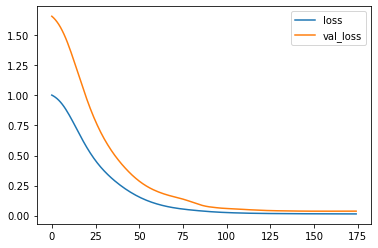

In [51]:
pd.DataFrame(oPredictiveModel.history.history).plot()

## Test

In [91]:
oPredictiveModel.load_weights(sModelName)

aPrediction = oPredictiveModel.predict(aInputTest)
aPrediction = aPrediction.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfPrediction = pd.DataFrame(aPrediction, index = ixTest, columns = ixOutputColums)

aActual = aOutputTest.reshape((-1, iForwardTimeWindow * iNrOutputFeatures))
dfActual =  pd.DataFrame(aActual, index = ixTest, columns = ixOutputColums)

for sOutputFeature in aOutputFeatures:
    sScalerFilePath = os.path.join(sModelName , "__scalers__")
    sScalerFilePath = os.path.join(sScalerFilePath , sColumn + ".sav")
    oScaler = pickle.load(open(sScalerFilePath, 'rb'))
    
    tplMaskFeature = (slice(None), slice(sOutputFeature))
    
    dfPrediction.loc[:,tplMaskFeature] = oScaler.inverse_transform(dfPrediction.loc[:, tplMaskFeature])
    dfActual.loc[:, tplMaskFeature] =  oScaler.inverse_transform(dfActual.loc[:, tplMaskFeature])

In [103]:
iComparisionTimeStep = 1

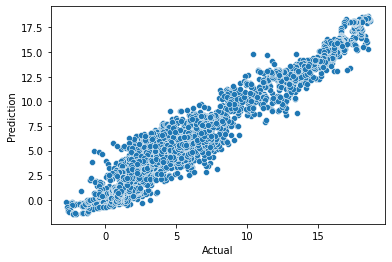

In [104]:
dfTestComparision = pd.DataFrame(dfPrediction.iloc[:,iComparisionTimeStep])
dfTestComparision = dfTestComparision.join(dfActual.iloc[:,iComparisionTimeStep], how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")

In [105]:
y_pred = dfPrediction.iloc[:, iComparisionTimeStep]
y_true = dfActual.iloc[:, iComparisionTimeStep]
aMetrics = [
        ('mean absolute error', mean_absolute_error(y_true, y_pred)),
        ('mean squared error', mean_squared_error(y_true, y_pred)),
        ('max error', max_error(y_true, y_pred)),
        ('r2 score', r2_score(y_true, y_pred))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:                1.065
       mean squared error:                1.879
                max error:                5.820
                 r2 score:                0.934


-342.81772239996434


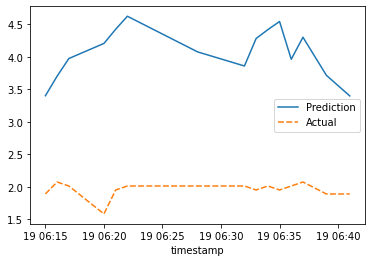

In [106]:
iFrom = 195 * 15
iTo = iFrom + 15

print(r2_score(dfActual.iloc[iFrom:iTo].loc[:, iComparisionTimeStep], dfPrediction.iloc[iFrom:iTo].loc[:, iComparisionTimeStep]))
sns.lineplot(data = dfTestComparision.iloc[iFrom:iTo])

# REFERENCES

https://www.tensorflow.org/guide/keras/train_and_evaluate#passing_data_to_multi-input_multi-output_models

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/

https://towardsdatascience.com/customize-loss-function-to-make-lstm-model-more-applicable-in-stock-price-prediction-b1c50e50b16c

https://keras.io/getting_started/faq/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

https://www.tensorflow.org/tutorials/structured_data/time_series